In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import tensorflow_model_optimization as tfmot
import keras
from keras.utils import plot_model
import pydot, graphviz
from random import random
#The model was trained on a tensorflow (Keras) version higher than the one you want to use to load the trained model. Find the compatible version of TensorFlow (Keras).
#https://stackoverflow.com/questions/60562216/cant-load-keras-model-using-rectifiedadam-optimizer
#from tensorflow_addons.optimizers import RectifiedAdam
#tf.keras.optimizers.RectifiedAdam = RectifiedAdam

In [2]:
df = pd.read_csv('../ml/dataset_management/refit/kettle/kettle_training_.csv').to_dict()
df['aggregate'] = {key: df['aggregate'][key] for key in range(10)}
df['kettle'] = {key: df['kettle'][key] for key in range(10)}

In [3]:
# Annahme: Input-Daten haben die Form (batch_size, sequence_length, num_features)
# https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
num_features = 5
window_length = 20
batch_size = num_features * 20
model = Sequential()
rnd = 1

In [4]:
'''
# Input Layer
model.add(Input(shape=(batch_size, window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length, 1)))
model.add(tf.keras.layers.Convolution2D(filters=16, kernel_size=(1, 5), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), padding='same'))
model.add(tf.keras.layers.Flatten())
#...
model.add(tf.keras.layers.Dense(batch_size * num_features, activation='linear'))
'''

"\n# Input Layer\nmodel.add(Input(shape=(batch_size, window_length)))\nmodel.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length, 1)))\nmodel.add(tf.keras.layers.Convolution2D(filters=16, kernel_size=(1, 5), padding='same'))\nmodel.add(tf.keras.layers.Activation('relu'))\nmodel.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), padding='same'))\nmodel.add(tf.keras.layers.Flatten())\n#...\nmodel.add(tf.keras.layers.Dense(batch_size * num_features, activation='linear'))\n"

In [5]:
# input layer
model.add(Input(shape=(batch_size, window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length)))
# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(num_features, activation="softmax"))

In [6]:
'''
# TensorBoard 2.15.1 at http://localhost:6006/
keras.callbacks.TensorBoard(
    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)
'''

'\n# TensorBoard 2.15.1 at http://localhost:6006/\nkeras.callbacks.TensorBoard(\n    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",\n    histogram_freq=0,  # How often to log histogram visualizations\n    embeddings_freq=0,  # How often to log embedding visualizations\n    update_freq="epoch",\n)  # How often to write logs (default: once per epoch)\n'

In [7]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])

# Anzeigen der Modellzusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 20)           0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           3904      
                                                                 
 batch_normalization (Batch  (None, 100, 64)           256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 100, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 64)           256       
 chNormalization)                                       

In [8]:
'''
# create random test data
xx = np.random.random((batch_size, window_length)).reshape((1, batch_size, window_length))
yy = np.random.random((batch_size * num_features)).reshape((1, batch_size * num_features))
'''

'\n# create random test data\nxx = np.random.random((batch_size, window_length)).reshape((1, batch_size, window_length))\nyy = np.random.random((batch_size * num_features)).reshape((1, batch_size * num_features))\n'

In [9]:
# feature1
def generate_feature(base, peak, width=6, amount=1, rnd=0, size=10) :
    a = np.array([])
    for t in range(amount) :
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
        a = np.append(a, [peak + (random() - 0.5) * abs(rnd) for i in np.arange(size // amount - 2)])
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
    a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(size % amount)]) # correction for uneven num_features
    return a

In [10]:
feature1 = generate_feature(base=0, peak=5, amount=3, rnd=1, size=10)
#print(feature1)
#plt.plot(feature1)

In [11]:
x = np.array([])
y = np.array([])
for f in range(num_features) :
    #print("f: ", f)
    for i in range(int(batch_size / num_features)) :
        #print("i: ",i)
        x = np.append(x, generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length))
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        y = np.append(y, new_targets)
        #print(y)
        #print("f, i, y[f]: ", f, " ", i, " ", y[f])

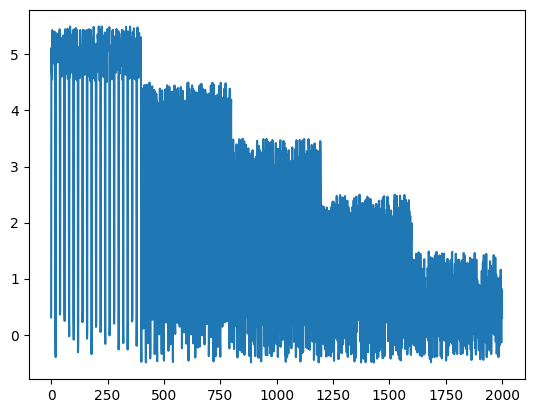

In [12]:
#print(x)
plt.plot(x)

In [13]:
print(np.size(x))
print(np.size(y))

2000
500


In [14]:
x = x.reshape((1, batch_size, window_length))
y = y.reshape((1, batch_size, num_features))

In [15]:
#print(x)
print(np.shape(x))
print(np.size(x))

(1, 100, 20)
2000


In [16]:
#y = y.reshape(1, 2, 2)
#print(y)
print(np.shape(y))
print(np.size(y))

(1, 100, 5)
500


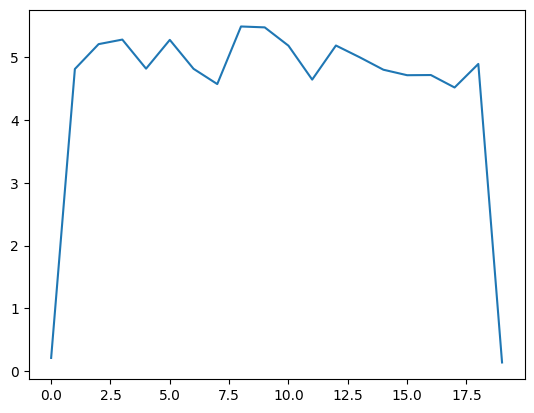

In [17]:
plt.plot(x[0][9])

In [18]:
print(y[0])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1.

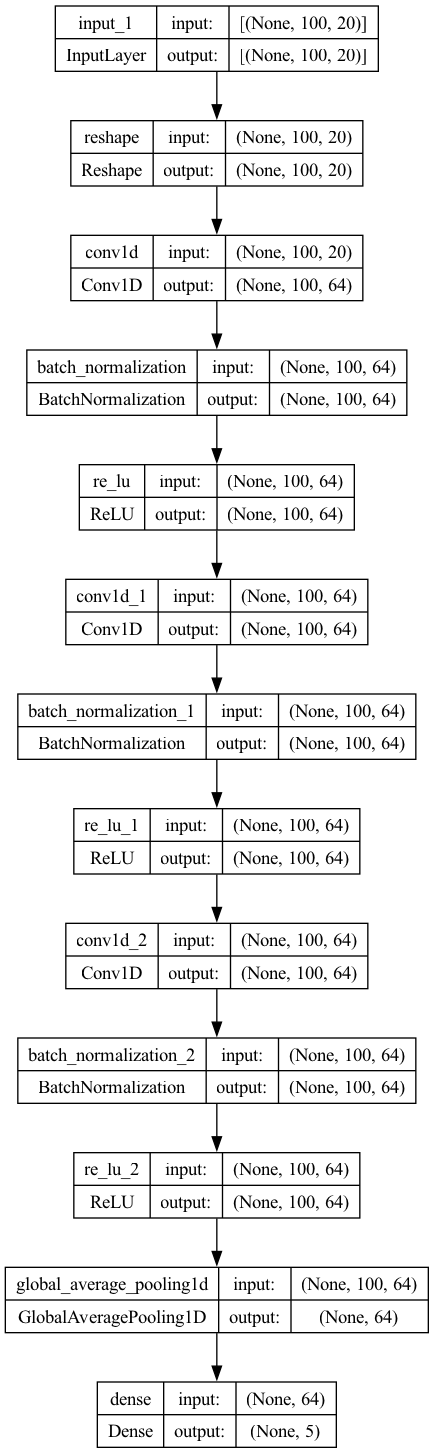

In [19]:
keras.utils.plot_model(model, "my_new_nilm_model.png", show_shapes=True)

In [20]:
# train the model
history = model.fit(
            x=x.reshape(1, batch_size, window_length),
            y=y.reshape(1, batch_size, num_features),
            batch_size=batch_size,
            epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 415ms/step - loss: 0.1728 - mse: 0.1728 - msle: 0.0876 - mae: 0.3200
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1711 - mse: 0.1711 - msle: 0.0865 - mae: 0.3200
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1697 - mse: 0.1697 - msle: 0.0855 - mae: 0.3200
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1684 - mse: 0.1684 - msle: 0.0846 - mae: 0.3200
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1672 - mse: 0.1672 - msle: 0.0837 - mae: 0.3200
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1661 - mse: 0.1661 - msle: 0.0830 - mae: 0.3200
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1650 - mse: 0.1650 - msle: 0.0822 - mae: 0.3200
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1641 - mse: 0.1641 - msle: 0.0816 - mae: 0.3200
Epoch 9/100
1/1 [=============

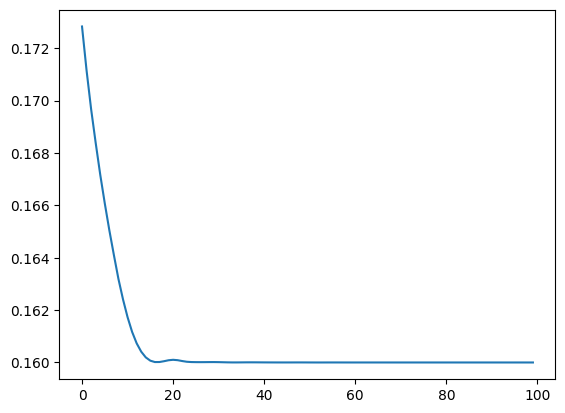

In [21]:
plt.plot(history.history['loss'])

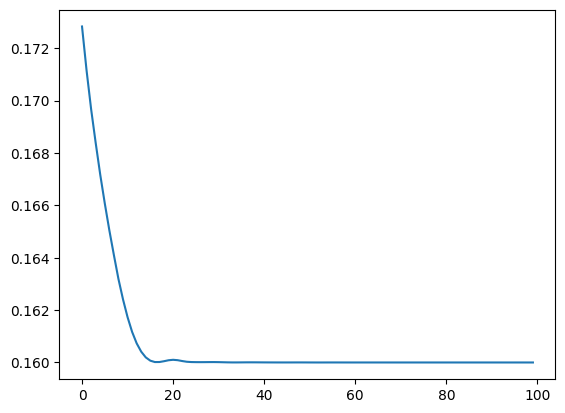

In [22]:
plt.plot(history.history['mse'])

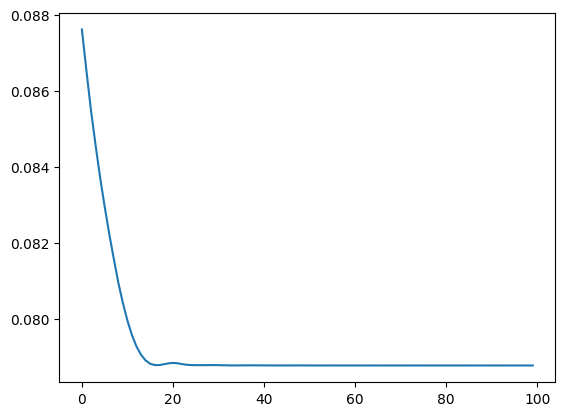

In [23]:
plt.plot(history.history['msle'])

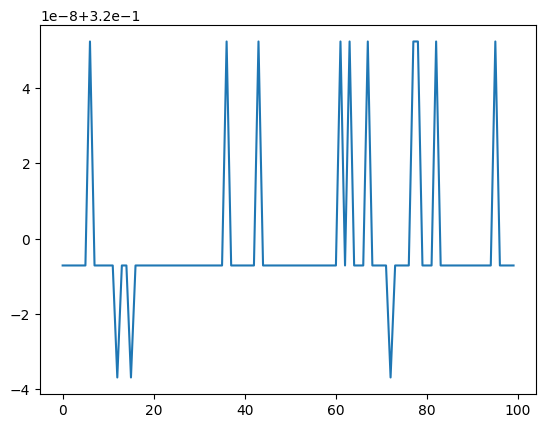

In [24]:
plt.plot(history.history['mae'])

In [25]:
model.save("my_new_nilm_model.keras")